In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model  import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers


In [6]:
warnings.filterwarnings("ignore")

In [2]:
JPM = yf.Ticker('JPM')
JPM = JPM.history(start='2014-12-29',end='2021-12-31')
JPM.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1765.000000,1765.000000,1765.000000,1765.000000,1.765000e+03,1765.000000,1765.0
mean,92.150688,93.008318,91.302414,92.150634,1.513972e+07,0.010561,0.0
std,32.584003,32.882706,32.299043,32.572711,6.646317e+06,0.087102,0.0
min,44.681977,45.383560,41.570080,44.559059,3.324300e+06,0.000000,0.0
25%,57.656314,57.925798,57.416999,57.690502,1.088610e+07,0.000000,0.0
50%,93.184599,94.177581,92.318731,93.221786,1.354240e+07,0.000000,0.0
75%,104.620874,105.376350,103.911245,104.580650,1.725090e+07,0.000000,0.0
max,170.417716,170.664397,168.276505,169.500061,5.619230e+07,1.000000,0.0


In [3]:
# Elimino la colonna 'Stock Splits', poichè è una colonna contenente tutti zeri, è aggiungo la colonna relativa ai rendimenti del titolo
# che serve soltanto per l'analisi esplorativa
JPM = JPM.drop('Stock Splits', axis = 1)
JPM['Rendimenti'] = JPM['Open'].diff()
JPM.describe()

,Open,High,Low,Close,Volume,Dividends,Rendimenti
count,1765.000000,1765.000000,1765.000000,1765.000000,1.765000e+03,1765.000000,1764.000000
mean,92.150688,93.008318,91.302414,92.150634,1.513972e+07,0.010561,0.060192
std,32.584003,32.882706,32.299043,32.572711,6.646317e+06,0.087102,1.613196
min,44.681977,45.383560,41.570080,44.559059,3.324300e+06,0.000000,-10.086377
25%,57.656314,57.925798,57.416999,57.690502,1.088610e+07,0.000000,-0.622688
50%,93.184599,94.177581,92.318731,93.221786,1.354240e+07,0.000000,0.070233
75%,104.620874,105.376350,103.911245,104.580650,1.725090e+07,0.000000,0.763085
max,170.417716,170.664397,168.276505,169.500061,5.619230e+07,1.000000,10.493416


ANALISI ESPLORATIVA:


Verrà effettuata un'analisi esplorativa sia grafica sull'andamento dei prezzi di apertura e dei rendimenti del titolo, sia volta a studiare la forza della correlazione serialedi ogni titolo ed eventuale presenza di cointegrazione fra i titoli.

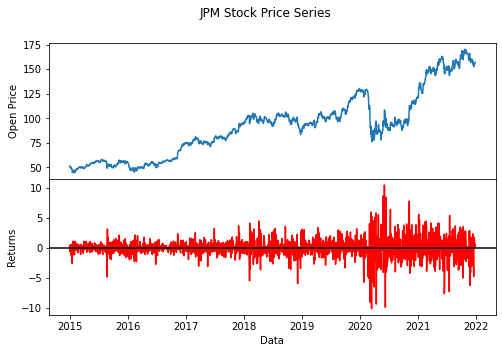

In [4]:
fig = plt.figure(figsize=(8,5))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
fig.suptitle('JPM Stock Price Series')
axs[0].plot(JPM['Open'])
axs[1].plot(JPM['Rendimenti'], color ="red")
axs[1].axhline(y=0.045864, color = "black", linestyle="solid")
axs[1].set_xlabel("Data")
axs[1].set_ylabel("Returns")
axs[0].set_ylabel("Open Price")
for ax in axs.flat:
    ax.label_outer()
plt.show()
# la serie mostra un forte trend, e una volatilità crescente con un cluster abbastanza corposo nell'ultimo periodo.
#fig.savefig("E:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\serie.pdf", bbox_inches='tight', format="pdf")


c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


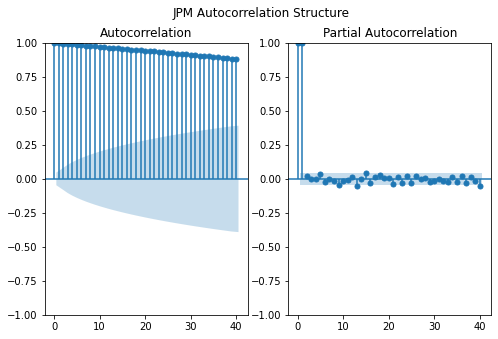

In [5]:
# ACF E PACF della serie dei prezzi
fig, ax = plt.subplots(1, 2, figsize=(8,5))
plot_acf(JPM['Open'], lags=40, ax=ax[0])
plot_pacf(JPM['Open'], lags=40, ax=ax[1])
plt.suptitle("JPM Autocorrelation Structure")
plt.show()
#fig.savefig("E:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\cor.pdf", bbox_inches='tight', format="pdf")

In [6]:
#Test ADF per la verifica dell'ipotesi nulla di radice unitaria
adfTest = adfuller(JPM['Open'], autolag = 'AIC')
dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
print('Augmented Dickey-Fuller Test Results:\n')
print(dfResults)
# non si rifiuta l'ipotesi nulla di radice unitaria

Augmented Dickey-Fuller Test Results:

ADF Test Statistic       -0.431580
P-Value                   0.904691
# Lags Used               5.000000
# Observations Used    1759.000000
dtype: float64


c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\axes\_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


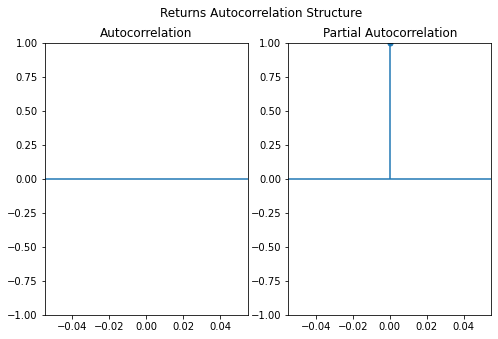

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(8,5))
plot_acf(JPM["Rendimenti"], lags=40, ax=ax[0])
plot_pacf(JPM["Rendimenti"], lags=40, ax=ax[1])
plt.suptitle("Returns Autocorrelation Structure")
plt.show()

MODELLAZIONE ARIMA



In [13]:
# creazione del train e del test set
size = int(len(JPM) * 0.836)
print(size)
dataset_train = JPM[0:size]
training_set = dataset_train.iloc[:, 0:1].values
dataset_test = JPM[size:]
test_set = dataset_test.iloc[:,0:1].values
print(training_set.shape)
print(test_set.shape)

1475
(1475, 1)
(290, 1)


In [33]:
history = [x for x in training_set]
predictions = list()
# walk-forward validation
for t in range(len(test_set)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit()
    output = model_fit.forecast(steps = 5)
    yhat = output[0]
    predictions.append(yhat)
    obs = test_set[t]
    history.append(obs)

In [22]:
print(model_fit.summary()) # si rifiuta l'ipotesi nulla di normalità dei residui; il Ljung box è non significativo e quindi il modello filtra la serie
# dalla dipendenza seriale

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1764
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -3344.409
Date:                Mon, 27 Jun 2022   AIC                           6692.818
Time:                        22:26:55   BIC                           6703.768
Sample:                             0   HQIC                          6696.864
                               - 1764                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0411      0.014     -2.948      0.003      -0.068      -0.014
sigma2         2.6016      0.042     62.621      0.000       2.520       2.683
Ljung-Box (L1) (Q):                   0.00   Jarque-

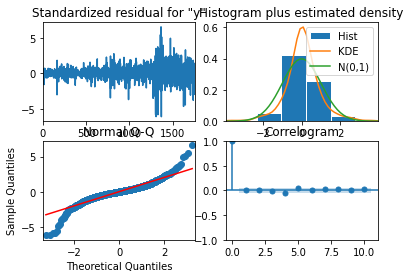

In [23]:
model_fit.plot_diagnostics() # forte asimmetria nella distribuzione dei residui
plt.show()

In [34]:
print(test_set.shape)
print(np.array(predictions).shape)

(290, 1)
(290,)


In [35]:
# valutazione delle previsioni
mse = mean_squared_error(test_set, predictions)
print('Mean Squared Error:\t',mse)

Mean Squared Error:	 4.794307605002736


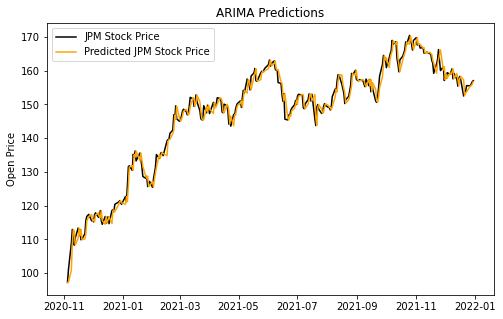

In [36]:
predictions = pd.DataFrame(predictions)
predictions= predictions.set_index(dataset_test.index)
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], color ="black", label = "JPM Stock Price")
plt.plot(predictions, color="orange", label = "Predicted JPM Stock Price")
plt.legend()
plt.ylabel("Open Price")
plt.title("ARIMA Predictions")
plt.show()
#fig.savefig("E:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\prev_arima.pdf", bbox_inches='tight', format="pdf")

In [37]:
# ARIMA(2,1,0)
history = [x for x in training_set]
predictions = list()
# walk-forward validation
for t in range(len(test_set)):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_set[t]
    history.append(obs)

In [38]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1764
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -3344.142
Date:                Mon, 27 Jun 2022   AIC                           6694.284
Time:                        22:33:30   BIC                           6710.708
Sample:                             0   HQIC                          6700.353
                               - 1764                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0404      0.014     -2.852      0.004      -0.068      -0.013
ar.L2          0.0174      0.014      1.227      0.220      -0.010       0.045
sigma2         2.6008      0.042     61.542      0.0

CONVOLUTIONAL NEURAL NETWORK

In [39]:
mc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = mc.fit_transform(training_set)
print(training_set_scaled.shape)

(1475, 1)


In [90]:
# Costruzione del set di training per la multi-step walk forward validation con finestra temporale di 5 giorni
X_train = []
y_train = []
temp = 5
for i in range(temp, training_set_scaled.shape[0], temp):
  X_train.append(training_set_scaled[i-temp:i])
  y_train.append(training_set_scaled[i:i+temp])
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(294, 5, 1)
(294, 5, 1)
(294, 5, 1)


In [91]:
# rete CNN base
model_5_CNN = keras.Sequential(
    [
     keras.Input(shape=(5,1)),
     layers.Conv1D(64, kernel_size = 3,activation='relu'),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(32, activation="relu"),
     layers.Dense(5, activation = "relu")
    ]
)
model_5_CNN.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 3, 64)             256       
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 1, 64)            0         
 g1D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 32)                2080      
                                                                 
 dense_27 (Dense)            (None, 5)                 165       
                                                                 
Total params: 2,501
Trainable params: 2,501
Non-trainable params: 0
___________________________________________________

In [92]:
batch_size = 4
epochs = 20
history = keras.callbacks.History()
model_5_CNN.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[['MSE']])
model_5_CNN.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks = [history])

Epoch 1/20
74/74 [==============================] - 1s 1ms/step - loss: 0.0373 - MSE: 0.0373
Epoch 2/20
74/74 [==============================] - 0s 1ms/step - loss: 0.0019 - MSE: 0.0019
Epoch 3/20
74/74 [==============================] - 0s 1ms/step - loss: 0.0014 - MSE: 0.0014
Epoch 4/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0014 - MSE: 0.0014
Epoch 5/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0015 - MSE: 0.0015  
Epoch 6/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0013 - MSE: 0.0013  
Epoch 7/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0014 - MSE: 0.0014
Epoch 8/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0014 - MSE: 0.0014  
Epoch 9/20
74/74 [==============================] - 0s 1ms/step - loss: 0.0014 - MSE: 0.0014
Epoch 10/20
74/74 [==============================] - 0s 1ms/step - loss: 0.0014 - MSE: 0.0014   
Epoch 11/20
74/74 [==============================] - 0s 1ms/

In [122]:
print(np.min(history.history['loss']))

0.001308912760578096


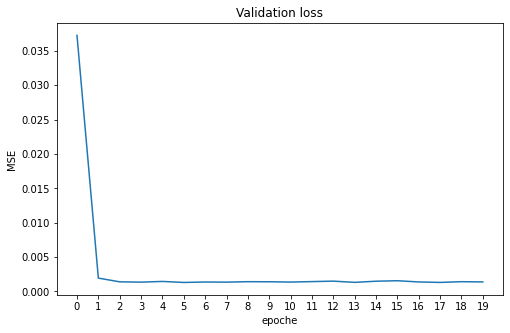

In [120]:
fig = plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.xticks(list(range(0,20)))
plt.title("Validation loss")
plt.xlabel("epoche")
plt.ylabel("MSE")
plt.show()
#fig.savefig("E:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\loss_cnn1.pdf", bbox_inches='tight', format="pdf")

In [98]:
real_stock_price = dataset_test.iloc[:, 0:1].values
print(real_stock_price.shape)

# creazione del test set
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - temp:].values
inputs = inputs.reshape(-1,1)
inputs = mc.transform(inputs)
X_test = []
for i in range(5, inputs.shape[0], 5):
  X_test.append(inputs[i-temp:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(290, 1)
(58, 5, 1)


In [99]:
predicted_stock_price = model_5_CNN.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
print(real_stock_price.shape)

(290, 1)


Mean Squared Error:	 19.199380435267397


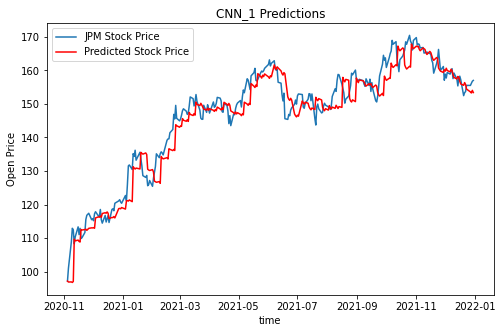

In [125]:
# MSE e rappresentazione delle previsioni
print("Mean Squared Error:\t", mean_squared_error(real_stock_price, predicted_stock_price))
predicted_stock_price = pd.DataFrame(predicted_stock_price)
predicted_stock_price= predicted_stock_price.set_index(dataset_test.index)
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("CNN_1 Predictions")
plt.legend()
plt.show()
#fig.savefig("E:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\prev_cnn1.pdf", bbox_inches='tight', format="pdf")

In [126]:
# MODIFICO IL LEARING RATE A 0.02
model_5_CNN_2 = keras.Sequential(
    [
     keras.Input(shape=(5,1)),
     layers.Conv1D(64, kernel_size = 3,activation='relu'),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(32, activation="relu"),
     layers.Dense(5, activation = "relu")
    ]
)
optimizer = keras.optimizers.Adam(learning_rate=0.02)
model_5_CNN_2.compile(loss=keras.losses.mean_squared_error, optimizer=optimizer, metrics=[['MSE']])
model_5_CNN_2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/20
74/74 [==============================] - 0s 1ms/step - loss: 0.0615 - MSE: 0.0615
Epoch 2/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0537 - MSE: 0.0537
Epoch 3/20
74/74 [==============================] - 0s 1ms/step - loss: 0.0270 - MSE: 0.0270
Epoch 4/20
74/74 [==============================] - 0s 1ms/step - loss: 0.0037 - MSE: 0.0037
Epoch 5/20
74/74 [==============================] - 0s 1ms/step - loss: 0.0034 - MSE: 0.0034
Epoch 6/20
74/74 [==============================] - 0s 1ms/step - loss: 0.0018 - MSE: 0.0018
Epoch 7/20
74/74 [==============================] - 0s 1ms/step - loss: 0.0021 - MSE: 0.0021   
Epoch 8/20
74/74 [==============================] - 0s 1ms/step - loss: 0.0023 - MSE: 0.0023  
Epoch 9/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0030 - MSE: 0.0030  
Epoch 10/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0025 - MSE: 0.0025  
Epoch 11/20
74/74 [==============================] - 0s 1ms/

In [50]:
predicted_stock_price = model_5_CNN_2.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
print(predicted_stock_price.shape)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
print(predicted_stock_price.shape)

(58, 5)
(290, 1)


Mean Squared Error:	 32.37026641478379


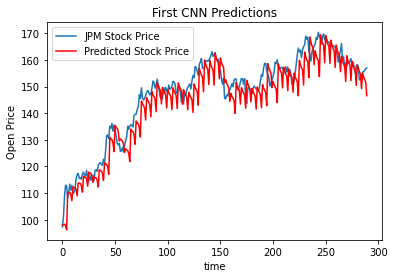

In [51]:
# MSE ed previsioni
print("Mean Squared Error:\t", mean_squared_error(real_stock_price, predicted_stock_price))
plt.plot(real_stock_price, label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()

In [56]:
# AUMENTO IL BATCH_SIZE A 10
model_5_CNN_3 = keras.Sequential(
    [
     keras.Input(shape=(5,1)),
     layers.Conv1D(64, kernel_size = 3,activation='relu'),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(32, activation="relu"),
     layers.Dense(5, activation = "relu")
    ]
)
model_5_CNN_3.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[['MSE']])
model_5_CNN_3.fit(X_train,y_train,epochs=20,batch_size=10)

Epoch 1/20
30/30 [==============================] - 0s 1ms/step - loss: 0.2173 - MSE: 0.2173
Epoch 2/20
30/30 [==============================] - 0s 1ms/step - loss: 0.2055 - MSE: 0.2055
Epoch 3/20
30/30 [==============================] - 0s 2ms/step - loss: 0.2047 - MSE: 0.2047
Epoch 4/20
30/30 [==============================] - 0s 1ms/step - loss: 0.2018 - MSE: 0.2018
Epoch 5/20
30/30 [==============================] - 0s 1ms/step - loss: 0.1280 - MSE: 0.1280
Epoch 6/20
30/30 [==============================] - 0s 1ms/step - loss: 0.0492 - MSE: 0.0492
Epoch 7/20
30/30 [==============================] - 0s 1ms/step - loss: 0.0089 - MSE: 0.0089
Epoch 8/20
30/30 [==============================] - 0s 1ms/step - loss: 0.0039 - MSE: 0.0039
Epoch 9/20
30/30 [==============================] - 0s 1ms/step - loss: 0.0024 - MSE: 0.0024
Epoch 10/20
30/30 [==============================] - 0s 1ms/step - loss: 0.0018 - MSE: 0.0018
Epoch 11/20
30/30 [==============================] - 0s 1ms/step - lo

Mean Squared Error:	 28.713371770672122


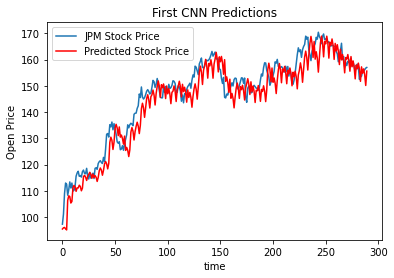

In [57]:
# MSE ed previsioni
predicted_stock_price = model_5_CNN_3.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
print("Mean Squared Error:\t", mean_squared_error(real_stock_price, predicted_stock_price))
plt.plot(real_stock_price, label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()

In [58]:
# AUMENTO IL NUMERO DI EPOCHE A 60
model_5_CNN_4 = keras.Sequential(
    [
     keras.Input(shape=(5,1)),
     layers.Conv1D(64, kernel_size = 3,activation='relu'),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(32, activation="relu"),
     layers.Dense(5, activation = "relu")
    ]
)
model_5_CNN_4.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[['MSE']])
model_5_CNN_4.fit(X_train,y_train,epochs=60,batch_size=4)

Epoch 1/60
74/74 [==============================] - 0s 1ms/step - loss: 0.1619 - MSE: 0.1619
Epoch 2/60
74/74 [==============================] - 0s 1ms/step - loss: 0.1368 - MSE: 0.1368
Epoch 3/60
74/74 [==============================] - 0s 1ms/step - loss: 0.0098 - MSE: 0.0098
Epoch 4/60
74/74 [==============================] - 0s 1ms/step - loss: 0.0015 - MSE: 0.0015   
Epoch 5/60
74/74 [==============================] - 0s 1ms/step - loss: 0.0015 - MSE: 0.0015  
Epoch 6/60
74/74 [==============================] - 0s 2ms/step - loss: 0.0016 - MSE: 0.0016  
Epoch 7/60
74/74 [==============================] - 0s 1ms/step - loss: 0.0014 - MSE: 0.0014
Epoch 8/60
74/74 [==============================] - 0s 1ms/step - loss: 0.0014 - MSE: 0.0014
Epoch 9/60
74/74 [==============================] - 0s 1ms/step - loss: 0.0017 - MSE: 0.0017   
Epoch 10/60
74/74 [==============================] - 0s 1ms/step - loss: 0.0015 - MSE: 0.0015   
Epoch 11/60
74/74 [==============================] - 0s 

Mean Squared Error:	 18.575743386054413


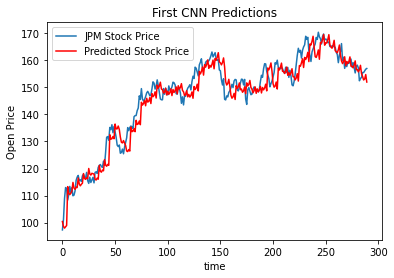

In [59]:
# MSE ed previsioni
predicted_stock_price = model_5_CNN_4.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
print("Mean Squared Error:\t", mean_squared_error(real_stock_price, predicted_stock_price))
plt.plot(real_stock_price, label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()

In [60]:
# AGGIUNGO UN LIVELLO CONVOLUTIVO IN PIù
model_5_CNN_5 = keras.Sequential(
    [
     keras.Input(shape=(5,1)),
     layers.Conv1D(64, kernel_size = 3,activation='relu'),
     layers.Conv1D(40, kernel_size = 2,activation='relu'),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(30, activation="relu"),
     layers.Dense(5, activation = "relu")
    ]
)
model_5_CNN_5.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 3, 64)             256       
                                                                 
 conv1d_8 (Conv1D)           (None, 2, 40)             5160      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 1, 40)            0         
 1D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 40)                0         
                                                                 
 dense_14 (Dense)            (None, 30)                1230      
                                                                 
 dense_15 (Dense)            (None, 5)                 155       
                                                      

In [61]:
model_5_CNN_5.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[['MSE']])
model_5_CNN_5.fit(X_train,y_train,epochs=20,batch_size=4)

Epoch 1/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0948 - MSE: 0.0948
Epoch 2/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0031 - MSE: 0.0031
Epoch 3/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0013 - MSE: 0.0013  
Epoch 4/20
74/74 [==============================] - 0s 1ms/step - loss: 0.0013 - MSE: 0.0013
Epoch 5/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0015 - MSE: 0.0015
Epoch 6/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0013 - MSE: 0.0013   
Epoch 7/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0014 - MSE: 0.0014
Epoch 8/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0013 - MSE: 0.0013  
Epoch 9/20
74/74 [==============================] - 0s 1ms/step - loss: 0.0014 - MSE: 0.0014
Epoch 10/20
74/74 [==============================] - 0s 1ms/step - loss: 0.0012 - MSE: 0.0012  
Epoch 11/20
74/74 [==============================] - 0s 1ms/

Mean Squared Error:	 31.197885694590013


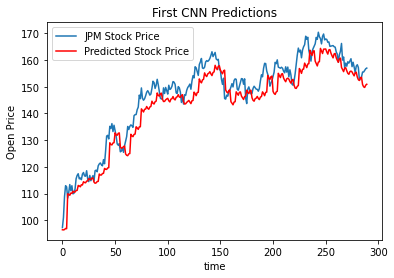

In [62]:
# MSE ed previsioni
predicted_stock_price = model_5_CNN_5.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
print("Mean Squared Error:\t", mean_squared_error(real_stock_price, predicted_stock_price))
plt.plot(real_stock_price, label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()

In [63]:
# USO COME FUNZIONE DI ATTIVAZIONE DEL LIVELLO DI OUTPUT LA FUNZIONE LINEARE
model_5_CNN_6 = keras.Sequential(
    [
     keras.Input(shape=(5,1)),
     layers.Conv1D(64, kernel_size = 2,activation='relu'),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(32, activation="relu"),
     layers.Dense(5, activation = "linear")
    ]
)
model_5_CNN_6.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 4, 64)             192       
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 32)                4128      
                                                                 
 dense_17 (Dense)            (None, 5)                 165       
                                                                 
Total params: 4,485
Trainable params: 4,485
Non-trainable params: 0
____________________________________________________

In [64]:
model_5_CNN_6.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[['MSE']])
model_5_CNN_6.fit(X_train,y_train,epochs=20,batch_size=4)

Epoch 1/20
74/74 [==============================] - 0s 1ms/step - loss: 0.0902 - MSE: 0.0902
Epoch 2/20
74/74 [==============================] - 0s 1ms/step - loss: 0.0037 - MSE: 0.0037
Epoch 3/20
74/74 [==============================] - 0s 1ms/step - loss: 0.0013 - MSE: 0.0013
Epoch 4/20
74/74 [==============================] - 0s 1ms/step - loss: 0.0012 - MSE: 0.0012
Epoch 5/20
74/74 [==============================] - 0s 1ms/step - loss: 0.0013 - MSE: 0.0013   
Epoch 6/20
74/74 [==============================] - 0s 1ms/step - loss: 0.0012 - MSE: 0.0012    
Epoch 7/20
74/74 [==============================] - 0s 1ms/step - loss: 0.0013 - MSE: 0.0013   
Epoch 8/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0015 - MSE: 0.0015  
Epoch 9/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0014 - MSE: 0.0014   
Epoch 10/20
74/74 [==============================] - 0s 1ms/step - loss: 0.0013 - MSE: 0.0013   
Epoch 11/20
74/74 [==============================] 

Mean Squared Error:	 48.102505475774954


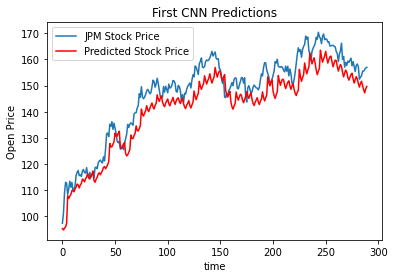

In [65]:
# MSE ed previsioni
predicted_stock_price = model_5_CNN_6.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
print("Mean Squared Error:\t", mean_squared_error(real_stock_price, predicted_stock_price))
plt.plot(real_stock_price, label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show() 

In [66]:
# WALK-FORWARD VALIDATION CON FINESTRA TEMPORALE DI 10 GIORNI
training_set_scaled_10 = np.delete(training_set_scaled, (range(1470,1475)), axis = 0)
print(training_set_scaled_10.shape)

(1470, 1)


In [78]:
X_train = []
y_train = []
temp = 10
for i in range(temp, training_set_scaled_10.shape[0], temp):
  X_train.append(training_set_scaled_10[i-temp:i, 0])
  y_train.append(training_set_scaled_10[i:i+temp-5, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(146, 10)
(146, 10, 1)
(146, 5)


In [74]:
model_10_CNN = keras.Sequential(
    [
     keras.Input(shape=(10,1)),
     layers.Conv1D(64, kernel_size = 2,activation='relu'),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(45, activation="relu"),
     layers.Dense(5, activation = "relu")
    ]
)
model_10_CNN.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 9, 64)             192       
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 4, 64)            0         
 g1D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 256)               0         
                                                                 
 dense_20 (Dense)            (None, 45)                11565     
                                                                 
 dense_21 (Dense)            (None, 5)                 230       
                                                                 
Total params: 11,987
Trainable params: 11,987
Non-trainable params: 0
_________________________________________________

In [79]:
batch_size = 4
epochs = 20
model_10_CNN.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[['MSE']])
model_10_CNN.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/20
37/37 [==============================] - 0s 1ms/step - loss: 0.1257 - MSE: 0.1257
Epoch 2/20
37/37 [==============================] - 0s 2ms/step - loss: 0.1040 - MSE: 0.1040
Epoch 3/20
37/37 [==============================] - 0s 2ms/step - loss: 0.1035 - MSE: 0.1035
Epoch 4/20
37/37 [==============================] - 0s 3ms/step - loss: 0.1036 - MSE: 0.1036
Epoch 5/20
37/37 [==============================] - 0s 1ms/step - loss: 0.1036 - MSE: 0.1036
Epoch 6/20
37/37 [==============================] - 0s 1ms/step - loss: 0.0971 - MSE: 0.0971
Epoch 7/20
37/37 [==============================] - 0s 1ms/step - loss: 0.0550 - MSE: 0.0550
Epoch 8/20
37/37 [==============================] - 0s 1ms/step - loss: 0.0529 - MSE: 0.0529
Epoch 9/20
37/37 [==============================] - 0s 1ms/step - loss: 0.0394 - MSE: 0.0394
Epoch 10/20
37/37 [==============================] - 0s 1ms/step - loss: 0.0033 - MSE: 0.0033
Epoch 11/20
37/37 [==============================] - 0s 1ms/step - lo

In [80]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
print(dataset_total.shape)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - temp:].values
print(inputs.shape)
inputs = inputs.reshape(-1,1)
inputs = mc.fit_transform(inputs)
print(inputs.shape)

X_test = []
for i in range(10, inputs.shape[0], 10):
  X_test.append(inputs[i-temp:i, 0])
X_test = np.array(X_test)
print(X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(1765,)
(300,)
(300, 1)
(29, 10)
(29, 10, 1)


In [81]:
predicted_stock_price = model_10_CNN(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
print(predicted_stock_price.shape)
print(real_stock_price.shape)
# MSE giornaliero


(145, 1)
(290, 1)


In [ ]:
# non eseguire
print("Mean Squared Error:\t", mean_squared_error(real_stock_price, predicted_stock_price))
plt.plot(real_stock_price, label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show() 

RETE RICORRENTE

In [82]:
# encoder
encoder_inputs = keras.Input(shape=(10,1))
encoder_cnn = keras.layers.Conv1D(64,kernel_size = 3, activation = "relu")(encoder_inputs)
encoder_cnn = keras.layers.Conv1D(64, kernel_size = 3, activation = "relu")(encoder_cnn)
encoder_cnn = keras.layers.MaxPooling1D(pool_size = 2)(encoder_cnn)
encoder_cnn = keras.layers.Flatten()(encoder_cnn)
encoder_outputs = encoder_cnn

#decoder
repeat = keras.layers.RepeatVector(5)(encoder_outputs)
decoder_lstm = keras.layers.LSTM(200, return_sequences=True, activation="relu")(repeat)
decoder = keras.layers.TimeDistributed(keras.layers.Dense(100, activation ="relu"))(decoder_lstm)
output = keras.layers.TimeDistributed(keras.layers.Dense(1, activation = "relu"))(decoder)

model_RNN = keras.Model(encoder_inputs, output)
model_RNN.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 10, 1)]           0         
                                                                 
 conv1d_14 (Conv1D)          (None, 8, 64)             256       
                                                                 
 conv1d_15 (Conv1D)          (None, 6, 64)             12352     
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 3, 64)            0         
 g1D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 192)               0         
                                                                 
 repeat_vector_1 (RepeatVect  (None, 5, 192)           0         
 or)                                                       

In [83]:
batch_size = 16
epochs = 20
model_RNN.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[['MSE']])
model_RNN.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/20
10/10 [==============================] - 1s 7ms/step - loss: 0.1204 - MSE: 0.1204
Epoch 2/20
10/10 [==============================] - 0s 10ms/step - loss: 0.0393 - MSE: 0.0393
Epoch 3/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0230 - MSE: 0.0230
Epoch 4/20
10/10 [==============================] - 0s 8ms/step - loss: 0.0135 - MSE: 0.0135
Epoch 5/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0058 - MSE: 0.0058
Epoch 6/20
10/10 [==============================] - 0s 8ms/step - loss: 0.0047 - MSE: 0.0047
Epoch 7/20
10/10 [==============================] - 0s 8ms/step - loss: 0.0038 - MSE: 0.0038
Epoch 8/20
10/10 [==============================] - 0s 8ms/step - loss: 0.0028 - MSE: 0.0028
Epoch 9/20
10/10 [==============================] - 0s 9ms/step - loss: 0.0024 - MSE: 0.0024
Epoch 10/20
10/10 [==============================] - 0s 10ms/step - loss: 0.0032 - MSE: 0.0032
Epoch 11/20
10/10 [==============================] - 0s 10ms/step -

In [84]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
print(dataset_total.shape)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 10:].values
print(inputs.shape)
inputs = inputs.reshape(-1,1)
inputs = mc.fit_transform(inputs)
print(inputs.shape)

X_test = []
for i in range(10, inputs.shape[0], 10):
  X_test.append(inputs[i-temp:i, 0])
X_test = np.array(X_test)
print(X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))
print(X_test.shape)

(1765,)
(300,)
(300, 1)
(29, 10)
(29, 10)


In [85]:
# MSE ed previsioni
predicted_stock_price = model_RNN.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(29,5)
print(predicted_stock_price.shape)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
print(predicted_stock_price.shape)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
print(predicted_stock_price.shape)

(29, 5)
(29, 5)
(145, 1)


In [86]:
# MSE ed previsioni
predicted_stock_price = model_RNN.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(29,5)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
print("Mean Squared Error:\t", mean_squared_error(real_stock_price, predicted_stock_price))
plt.plot(real_stock_price, label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [290, 145]